In [7]:
import os
import torch
from torch import nn
import pandas as pd
from src.helpers import get_project_dir
from src.ml.datasets import CustomDataset
from src.ml.models import MarkerModel
from src.ml.trainers import trainer
from src.ml.logging_functions import callback
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from src.ml.auxiliary_functions import load_model, load_tokenizer, tokenize_data, clear_gpu_memory, get_text_log, get_scalar_log

In [8]:
PROJECT_PATH = get_project_dir()
PATH_TO_DATA = os.path.join(PROJECT_PATH, 'data/marked/')
LOG_DIR = os.path.join(PROJECT_PATH, 'log/experiment_marker_1')
PATH_TO_MODELS = os.path.join(PROJECT_PATH, 'models')

# Loading model and tokenizer

In [ ]:
model_checkpoint = "sismetanin/sbert-ru-sentiment-rusentiment"

In [ ]:
tokenizer = load_tokenizer(model_checkpoint, use_fast=False)

In [ ]:
model = load_model(model_checkpoint, n_labels=2)

# Loading data

In [ ]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, "titles_marked.csv"))

# Splitting data

In [ ]:
traindata, testdata = train_test_split(data, test_size=0.1, random_state=42)
traindata = traindata.reset_index(drop=True)
testdata = testdata.reset_index(drop=True)

# Tokenizing data

In [ ]:
traindataset = tokenize_data(traindata, tokenizer, max_length=19, dataset_cls=CustomDataset)
testdataset = tokenize_data(testdata, tokenizer, max_length=19, dataset_cls=CustomDataset)

# Setting up callback

In [ ]:
writer = SummaryWriter(log_dir = LOG_DIR)
call = callback(writer, testdataset, loss_function=nn.CrossEntropyLoss(), batch_size=128,
                eval_steps=50)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir LOG_DIR --port 8890

# Fine-tuning

In [ ]:
clear_gpu_memory()

n_epochs = 15
batch_size = 128
lr = 5e-4

clf = trainer(n_epochs=n_epochs,
               batch_size=batch_size,
               train_dataset=traindataset,
               model=MarkerModel(pre_trained_model=model,
                                 n_targets=2,
                                 input_size=1024, hidden_layers=[256, 128, 64],
                                 p=0.1,
                                 train_only_head=True).to('cuda'),
               loss_function=nn.CrossEntropyLoss(),
               optimizer=torch.optim.Adam,
               scheduler=None,
               scheduler_params=None,
               lr = lr,
               rs = 42,
               callback = call)

In [ ]:
torch.save(clf, os.path.join(PATH_TO_MODELS, "marker_model.pt"))

In [ ]:
writer.close()

# Results

In [9]:
from src.helpers import smooth
from src.plotters import line_plot

In [11]:
PATH_TO_LOG1 = os.path.join(LOG_DIR, 'TRAIN')
PATH_TO_LOG2 = os.path.join(LOG_DIR, 'TEST')
steps1, logs1 = get_scalar_log(path=PATH_TO_LOG1, filename=os.listdir(PATH_TO_LOG1)[0])
steps2, logs2 = get_scalar_log(path=PATH_TO_LOG2, filename=os.listdir(PATH_TO_LOG2)[0])
logs1 = smooth(logs1, weight=0.9)
logs2 = smooth(logs2, weight=0.9)

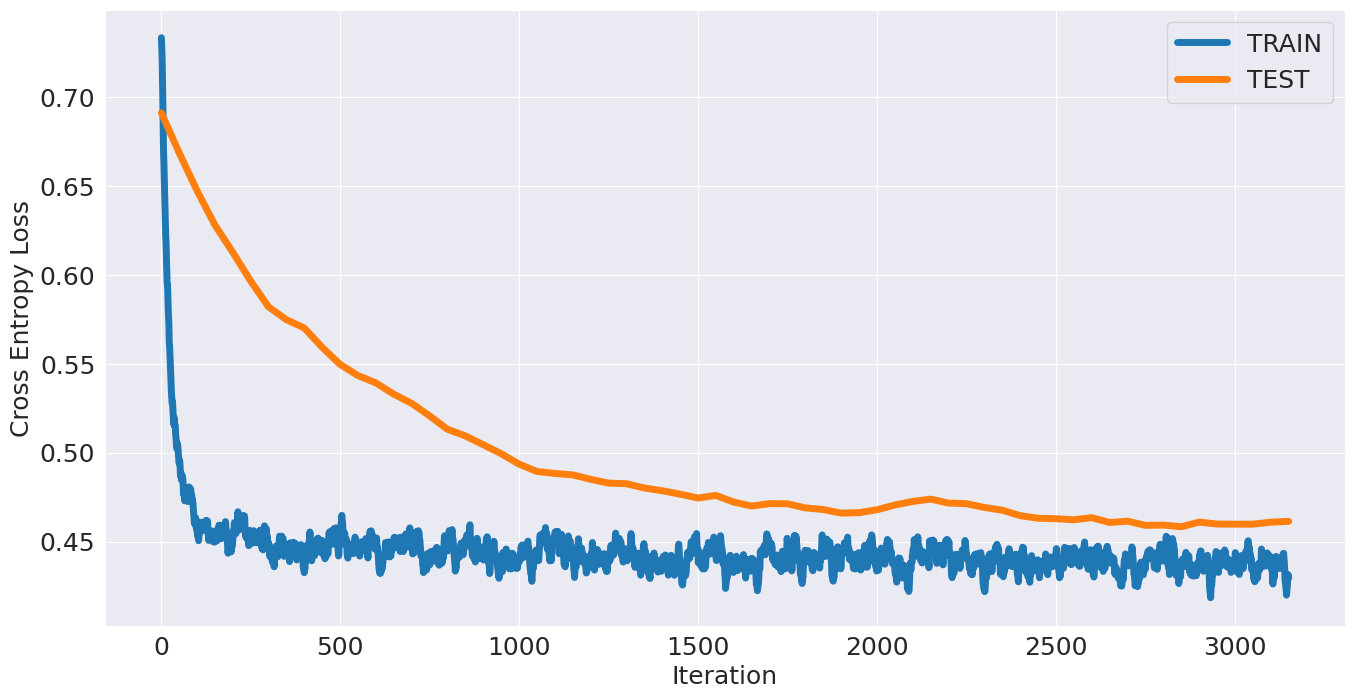

In [12]:
line_plot([steps1, steps2], [logs1, logs2], fs=18, lw=5, x_label='Iteration', y_label='Cross Entropy Loss',
          labels=['TRAIN', 'TEST'], multiple=True)